Output 'durasi_penyiraman' tidak ditemukan untuk data: [16 30 56]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 15  14 301]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 12  19 186]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 12  19 186]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 20  16 557]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 25  12 593]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [16 30 56]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 15  14 301]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 12  19 186]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 19  12 221]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 20  16 557]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 25  12 593]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [16 30 56]
Output 'durasi_penyiraman' tidak ditemukan untuk data: [ 15  14 301]
Output 'durasi_penyiraman' tidak ditemukan 

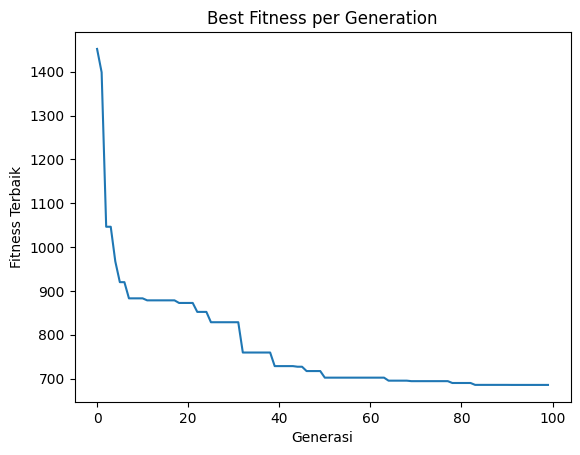

Optimal Parameters: [16.94579523 35.9896924  59.20954401 19.31237935 64.40482011 92.11359559
  2.69483976  9.81363044 95.05422732  1.10891286 32.1958774  45.80085182
 47.38971045 75.97921228 90.1457883  -3.56543304 37.83311573 81.550017  ]


In [9]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
import matplotlib.pyplot as plt

# Data dari slide 101 (input: suhu dan kelembaban, output: durasi penyiraman)
train_data = np.array([
    [20, 16, 557], [25, 12, 593], [16, 30, 56], [15, 14, 301],
    [27, 10, 434], [12, 19, 186], [19, 12, 221], [28, 8, 473]
])

test_data = np.array([
    [35, 6, 764], [20, 17, 209]
])

# Fungsi keanggotaan fuzzy untuk input Suhu dan Kelembaban
suhu = ctrl.Antecedent(np.arange(0, 41, 1), 'suhu')
kelembaban = ctrl.Antecedent(np.arange(0, 101, 1), 'kelembaban')

# Fungsi keanggotaan fuzzy untuk output Durasi Penyiraman
durasi_penyiraman = ctrl.Consequent(np.arange(0, 1001, 1), 'durasi_penyiraman')

# Inisialisasi batas fungsi keanggotaan (dioptimalkan oleh GA)
def init_membership_functions():
    suhu['dingin'] = fuzz.trimf(suhu.universe, [0, 0, 15])
    suhu['sedang'] = fuzz.trimf(suhu.universe, [10, 20, 30])
    suhu['panas'] = fuzz.trimf(suhu.universe, [25, 40, 40])
    
    kelembaban['rendah'] = fuzz.trimf(kelembaban.universe, [0, 0, 50])
    kelembaban['sedang'] = fuzz.trimf(kelembaban.universe, [25, 50, 75])
    kelembaban['tinggi'] = fuzz.trimf(kelembaban.universe, [50, 100, 100])

    durasi_penyiraman['singkat'] = fuzz.trimf(durasi_penyiraman.universe, [0, 0, 500])
    durasi_penyiraman['lama'] = fuzz.trimf(durasi_penyiraman.universe, [300, 1000, 1000])

init_membership_functions()

# Aturan fuzzy (akan dioptimalkan dengan GA)
def create_initial_rules():
    rule1 = ctrl.Rule(suhu['dingin'] & kelembaban['rendah'], durasi_penyiraman['lama'])
    rule2 = ctrl.Rule(suhu['panas'] & kelembaban['tinggi'], durasi_penyiraman['singkat'])
    rule3 = ctrl.Rule(suhu['sedang'] & kelembaban['sedang'], durasi_penyiraman['lama'])
    
    return [rule1, rule2, rule3]

# Sistem kontrol fuzzy
def create_fuzzy_system(rules):
    durasi_ctrl = ctrl.ControlSystem(rules)
    durasi_sim = ctrl.ControlSystemSimulation(durasi_ctrl)
    return durasi_sim

# Fungsi untuk memastikan a <= b <= c
def ensure_valid_bounds(individual):
    for i in range(0, len(individual), 3):
        individual[i:i+3] = sorted(individual[i:i+3])  # Pastikan a <= b <= c untuk setiap segitiga
    return individual

# Algoritma Genetika (Optimasi Batas Fungsi Keanggotaan)
def fitness_function(individual):
    # Pastikan batas valid sebelum menghitung fitness
    individual = ensure_valid_bounds(individual)
    
    # Membuat batas-batas baru berdasarkan individu
    suhu['dingin'] = fuzz.trimf(suhu.universe, individual[0:3])
    suhu['sedang'] = fuzz.trimf(suhu.universe, individual[3:6])
    suhu['panas'] = fuzz.trimf(suhu.universe, individual[6:9])
    
    kelembaban['rendah'] = fuzz.trimf(kelembaban.universe, individual[9:12])
    kelembaban['sedang'] = fuzz.trimf(kelembaban.universe, individual[12:15])
    kelembaban['tinggi'] = fuzz.trimf(kelembaban.universe, individual[15:18])
    
    # Menghitung error antara hasil fuzzy dan data sebenarnya
    rules = create_initial_rules()
    durasi_sim = create_fuzzy_system(rules)
    error = 0
    
    for data in train_data:
        durasi_sim.input['suhu'] = data[0]
        durasi_sim.input['kelembaban'] = data[1]
        durasi_sim.compute()
        
        # Periksa apakah output benar-benar tersedia
        if 'durasi_penyiraman' in durasi_sim.output:
            output = durasi_sim.output['durasi_penyiraman']
        else:
            print(f"Output 'durasi_penyiraman' tidak ditemukan untuk data: {data}")
            output = 0  # Atur output default jika terjadi masalah
        
        error += abs(output - data[2])
    
    return error

# Inisialisasi populasi
def init_population(pop_size, n_params):
    return [ensure_valid_bounds(np.random.uniform(0, 100, n_params)) for _ in range(pop_size)]

# Proses crossover dan mutasi
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1)-2)
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    
    # Pastikan batas valid setelah crossover
    return ensure_valid_bounds(child1), ensure_valid_bounds(child2)

def mutate(individual, mutation_rate=0.01):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] += random.uniform(-5, 5)
    
    # Pastikan batas valid setelah mutasi
    return ensure_valid_bounds(individual)

# Algoritma Genetika
def genetic_algorithm(pop_size=20, generations=100, mutation_rate=0.01):
    population = init_population(pop_size, 18)  # 18 parameter untuk optimasi suhu dan kelembaban
    best_fitness_history = []  # Untuk menyimpan fitness terbaik di setiap generasi
    
    for generation in range(generations):
        population = sorted(population, key=lambda x: fitness_function(x))
        new_population = population[:pop_size//2]  # Seleksi
        
        # Proses crossover dan mutasi
        while len(new_population) < pop_size:
            parent1, parent2 = random.sample(population[:pop_size//2], 2)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        
        population = new_population
        
        # Ambil fitness terbaik di generasi saat ini
        best_fitness = fitness_function(population[0])
        best_fitness_history.append(best_fitness)
        print(f'Generation {generation+1}, Best Fitness: {best_fitness}')  # Menampilkan hasil setiap generasi
    
    # Setelah selesai, tampilkan hasil akhirnya
    print(f'Optimal parameters: {population[0]}')
    return population[0], best_fitness_history

# Menjalankan Algoritma Genetika untuk menemukan batas optimal
optimal_params, fitness_history = genetic_algorithm()

# Visualisasi Fitness History (Grafik Fitness per Generasi)
plt.plot(fitness_history)
plt.title('Best Fitness per Generation')
plt.xlabel('Generasi')
plt.ylabel('Fitness Terbaik')
plt.show()

# Tampilkan Parameter Optimal
print(f"Optimal Parameters: {optimal_params}")
